In [1]:
from Trainmodel import traindcnncoxmodel,traincnncoxmodel
#from utils import avgcindex

2024-04-12 10:45:43.705252: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" 
import numpy as np
import pandas as pd
#from model import cnncox,dcnncox,nncox
from earlystoping import MyCallback
from utils import nll,avgcindex,setup_seed
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold,train_test_split
from lifelines.utils import concordance_index
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense,Dropout,Input,Flatten,concatenate
from tensorflow.keras.regularizers import l2


GENE_2_counts_normalized.subject_unique.metadata.all.tsv

was created from the REdiscoverTE output converted to a tsv.

The metadata came from Eduardo's initial gbm_train/gbm_test data files.


In [3]:

cancer_name='TCGA'
Cindex=[]

current_path='../data/our/'
output_path=current_path+'/GENE_2_counts_normalized.subject_unique.metadata.all.tsv'
save_path="../save model/our/my2DCNNCox/"
os.makedirs(save_path,exist_ok=True)


In [4]:

seed=42

setup_seed(seed)

df_exp=pd.read_csv(output_path,index_col=0,sep="\t",low_memory=False)


In [5]:
df_exp.head()

,sex,IDH,x1p19q,TERT,MGMT,Age,Survival_months,Vital_status,EGFR_re,CDKN2A_re,...,ENSG00000284649,ENSG00000284671,ENSG00000284680,ENSG00000284684,ENSG00000284691,ENSG00000284701,ENSG00000284723,"ENSG00000284733,ENSG00000284662",ENSG00000284741,NA
IID,,,,,,,,,,,,,,,,,,,,,
02-0047,male,WT,non-codel,NaN,Unmethylated,78,14.718995,1,Wildtype,Deleted,...,7.766,9.993,0,0.0,47.574,0,1,0.0,0.0,569.221
02-0055,female,WT,non-codel,NaN,Unmethylated,62,2.496972,1,Amplified,Wildtype,...,10.742,0.000,0,0.0,25.980,0,0,0.0,0.0,491.114
02-2485,male,WT,non-codel,Mutant,Unmethylated,53,15.441803,0,Amplified,Wildtype,...,5.379,0.000,0,0.0,69.000,0,1,0.0,0.0,717.150
02-2486,male,WT,non-codel,NaN,Unmethylated,64,16.197466,0,Amplified,Deleted,...,2.037,4.746,0,0.0,49.948,0,0,0.0,0.0,274.183
06-0125,female,WT,non-codel,Mutant,Methylated,63,47.573895,1,Amplified,Deleted,...,8.879,4.237,0,0.0,122.020,0,1,4.0,0.0,657.634


In [6]:
df_exp.drop(columns=['IDH','x1p19q','TERT','MGMT'],inplace=True)
df_exp.head()


# EGFR_re, CDKN2A_re ?

# what is the column "NA" from?

,sex,Age,Survival_months,Vital_status,EGFR_re,CDKN2A_re,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,...,ENSG00000284649,ENSG00000284671,ENSG00000284680,ENSG00000284684,ENSG00000284691,ENSG00000284701,ENSG00000284723,"ENSG00000284733,ENSG00000284662",ENSG00000284741,NA
IID,,,,,,,,,,,,,,,,,,,,,
02-0047,male,78,14.718995,1,Wildtype,Deleted,2350.460,1.000,633.000,439.035,...,7.766,9.993,0,0.0,47.574,0,1,0.0,0.0,569.221
02-0055,female,62,2.496972,1,Amplified,Wildtype,2893.011,825.001,2382.838,569.035,...,10.742,0.000,0,0.0,25.980,0,0,0.0,0.0,491.114
02-2485,male,53,15.441803,0,Amplified,Wildtype,4940.435,5.000,1128.869,695.463,...,5.379,0.000,0,0.0,69.000,0,1,0.0,0.0,717.150
02-2486,male,64,16.197466,0,Amplified,Deleted,4338.707,7.000,1089.000,588.688,...,2.037,4.746,0,0.0,49.948,0,0,0.0,0.0,274.183
06-0125,female,63,47.573895,1,Amplified,Deleted,3621.526,6.000,1226.225,632.096,...,8.879,4.237,0,0.0,122.020,0,1,4.0,0.0,657.634


In [7]:
#df_exp.fillna(0,inplace=True)

if 'sex' in df_exp.columns:
    df_exp['sex'].replace(to_replace={'female':0, 'male':1}, inplace=True)
if 'MGMT' in df_exp.columns:
    df_exp['MGMT'].replace(to_replace={'Unmethylated':0, 'Methylated':1}, inplace=True)
if 'EGFR_re' in df_exp.columns:
    df_exp['EGFR_re'].replace(to_replace={"Wildtype":0, "Amplified":1}, inplace=True)
if 'CDKN2A_re' in df_exp.columns:
    df_exp['CDKN2A_re'].replace(to_replace={"Wildtype":0, "Amplified":1, "Deleted":2}, inplace=True)

df_exp.head()


,sex,Age,Survival_months,Vital_status,EGFR_re,CDKN2A_re,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,...,ENSG00000284649,ENSG00000284671,ENSG00000284680,ENSG00000284684,ENSG00000284691,ENSG00000284701,ENSG00000284723,"ENSG00000284733,ENSG00000284662",ENSG00000284741,NA
IID,,,,,,,,,,,,,,,,,,,,,
02-0047,1,78,14.718995,1,0,2,2350.460,1.000,633.000,439.035,...,7.766,9.993,0,0.0,47.574,0,1,0.0,0.0,569.221
02-0055,0,62,2.496972,1,1,0,2893.011,825.001,2382.838,569.035,...,10.742,0.000,0,0.0,25.980,0,0,0.0,0.0,491.114
02-2485,1,53,15.441803,0,1,0,4940.435,5.000,1128.869,695.463,...,5.379,0.000,0,0.0,69.000,0,1,0.0,0.0,717.150
02-2486,1,64,16.197466,0,1,2,4338.707,7.000,1089.000,588.688,...,2.037,4.746,0,0.0,49.948,0,0,0.0,0.0,274.183
06-0125,0,63,47.573895,1,1,2,3621.526,6.000,1226.225,632.096,...,8.879,4.237,0,0.0,122.020,0,1,4.0,0.0,657.634


In [8]:
gene_exp=df_exp.dropna(axis=0,subset = ["Vital_status", "Survival_months"])

E=np.array(gene_exp.pop("Vital_status"))
Y=np.array(gene_exp.pop("Survival_months"))

In [9]:
gene_exp.head()

,sex,Age,EGFR_re,CDKN2A_re,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,...,ENSG00000284649,ENSG00000284671,ENSG00000284680,ENSG00000284684,ENSG00000284691,ENSG00000284701,ENSG00000284723,"ENSG00000284733,ENSG00000284662",ENSG00000284741,NA
IID,,,,,,,,,,,,,,,,,,,,,
02-0047,1,78,0,2,2350.460,1.000,633.000,439.035,304.000,534.288,...,7.766,9.993,0,0.0,47.574,0,1,0.0,0.0,569.221
02-0055,0,62,1,0,2893.011,825.001,2382.838,569.035,497.997,1123.424,...,10.742,0.000,0,0.0,25.980,0,0,0.0,0.0,491.114
02-2485,1,53,1,0,4940.435,5.000,1128.869,695.463,743.572,503.997,...,5.379,0.000,0,0.0,69.000,0,1,0.0,0.0,717.150
02-2486,1,64,1,2,4338.707,7.000,1089.000,588.688,276.264,827.419,...,2.037,4.746,0,0.0,49.948,0,0,0.0,0.0,274.183
06-0125,0,63,1,2,3621.526,6.000,1226.225,632.096,602.204,250.999,...,8.879,4.237,0,0.0,122.020,0,1,4.0,0.0,657.634


In [10]:
E.shape

(118,)

In [11]:
E[0:15]

array([1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0])

In [12]:
E

array([1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1])

In [13]:
Y.shape

(118,)

In [14]:
Y[0:15]

array([14.7189952,  2.4969724, 15.441803 , 16.1974657, 47.5738952,
       12.9448306, 11.8934738, 10.2835837,  7.1623682,  5.4210585,
       13.6019286,  1.0842117, 12.484862 ,  4.928235 ,  9.2650818])

In [15]:
len(gene_exp.columns)

55666


Add a number of columns to make the dataframe column count a square ( 236 x 236 = 55696 )


In [16]:
for i in range(55696-len(gene_exp.columns)):
    print("extra"+str(i))
    gene_exp["extra"+str(i)]=0

extra0
extra1
extra2
extra3
extra4
extra5
extra6
extra7
extra8
extra9
extra10
extra11
extra12
extra13
extra14
extra15
extra16
extra17
extra18
extra19
extra20
extra21
extra22
extra23
extra24
extra25
extra26
extra27
extra28
extra29


/var/folders/cq/4gq41jhd0tbcx2l74n_7g0nw0000gn/T/ipykernel_88834/3826403141.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  gene_exp["extra"+str(i)]=0
/var/folders/cq/4gq41jhd0tbcx2l74n_7g0nw0000gn/T/ipykernel_88834/3826403141.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  gene_exp["extra"+str(i)]=0
/var/folders/cq/4gq41jhd0tbcx2l74n_7g0nw0000gn/T/ipykernel_88834/3826403141.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performan

In [17]:
len(gene_exp.columns)

55696

In [18]:
X=np.array(gene_exp)



In [19]:
X.shape

(118, 55696)

In [20]:
X[0:5,0:5]

array([[1.000000e+00, 7.800000e+01, 0.000000e+00, 2.000000e+00,
        2.350460e+03],
       [0.000000e+00, 6.200000e+01, 1.000000e+00, 0.000000e+00,
        2.893011e+03],
       [1.000000e+00, 5.300000e+01, 1.000000e+00, 0.000000e+00,
        4.940435e+03],
       [1.000000e+00, 6.400000e+01, 1.000000e+00, 2.000000e+00,
        4.338707e+03],
       [0.000000e+00, 6.300000e+01, 1.000000e+00, 2.000000e+00,
        3.621526e+03]])

In [21]:
X=X.astype('float64')

In [22]:
X.shape

(118, 55696)

In [23]:
X[0:5,0:5]

array([[1.000000e+00, 7.800000e+01, 0.000000e+00, 2.000000e+00,
        2.350460e+03],
       [0.000000e+00, 6.200000e+01, 1.000000e+00, 0.000000e+00,
        2.893011e+03],
       [1.000000e+00, 5.300000e+01, 1.000000e+00, 0.000000e+00,
        4.940435e+03],
       [1.000000e+00, 6.400000e+01, 1.000000e+00, 2.000000e+00,
        4.338707e+03],
       [0.000000e+00, 6.300000e+01, 1.000000e+00, 2.000000e+00,
        3.621526e+03]])

In [24]:
# Remove the first two columns (OS and OS.time)
#X=X[:,2:]

In [25]:
X.shape

(118, 55696)

In [26]:
X[0:5,0:5]

array([[1.000000e+00, 7.800000e+01, 0.000000e+00, 2.000000e+00,
        2.350460e+03],
       [0.000000e+00, 6.200000e+01, 1.000000e+00, 0.000000e+00,
        2.893011e+03],
       [1.000000e+00, 5.300000e+01, 1.000000e+00, 0.000000e+00,
        4.940435e+03],
       [1.000000e+00, 6.400000e+01, 1.000000e+00, 2.000000e+00,
        4.338707e+03],
       [0.000000e+00, 6.300000e+01, 1.000000e+00, 2.000000e+00,
        3.621526e+03]])

In [27]:
scaler=StandardScaler().fit(X)

In [28]:
X[0:5,0:5]

array([[1.000000e+00, 7.800000e+01, 0.000000e+00, 2.000000e+00,
        2.350460e+03],
       [0.000000e+00, 6.200000e+01, 1.000000e+00, 0.000000e+00,
        2.893011e+03],
       [1.000000e+00, 5.300000e+01, 1.000000e+00, 0.000000e+00,
        4.940435e+03],
       [1.000000e+00, 6.400000e+01, 1.000000e+00, 2.000000e+00,
        4.338707e+03],
       [0.000000e+00, 6.300000e+01, 1.000000e+00, 2.000000e+00,
        3.621526e+03]])

In [29]:
X=scaler.transform(X)

In [30]:
X[0:5,0:5]

array([[ 0.81361651,  1.22306379, -3.48010217,  0.50589175, -0.69648768],
       [-1.22908027, -0.02108731,  0.28734789, -2.08955288, -0.43649364],
       [ 0.81361651, -0.7209223 ,  0.28734789, -2.08955288,  0.5446455 ],
       [ 0.81361651,  0.13443158,  0.28734789,  0.50589175,  0.25629346],
       [-1.22908027,  0.05667214,  0.28734789,  0.50589175, -0.08738443]])

In [31]:
X.shape

(118, 55696)

Range 
Index 
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 236, 236, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 236, 1, 128)          30336     ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 1, 236, 8)            1896      ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 118, 1, 128)          0         ['conv2d[0][0]']              
 D)                                                                             

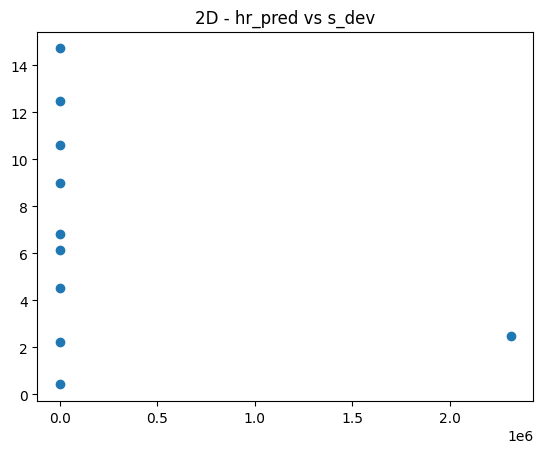

24/24 [==============================] - 0s 1ms/step
[[3.0092642e+03]
 [2.7806780e+06]
 [1.4160549e+03]
 [5.9264407e-02]
 [1.4080930e-03]
 [1.0728226e+05]
 [1.0636081e+02]
 [7.3923028e-01]
 [1.4709601e+00]
 [4.3641847e-01]
 [2.7359873e+01]
 [1.2901807e+03]
 [9.5372801e+00]
 [4.5970596e+02]
 [7.3071770e-02]
 [5.2626487e-03]
 [1.7881710e+01]
 [1.8713482e-02]
 [2.2895393e+03]
 [5.9234173e+01]
 [2.2649025e+04]
 [5.4102659e+00]
 [3.3844578e+01]
 [7.4701738e+05]]


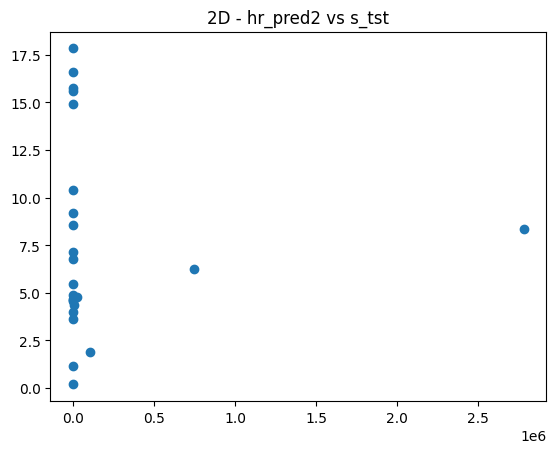

Index 
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 236, 236, 1)]        0         []                            
                                                                                                  
 conv2d_2 (Conv2D)           (None, 236, 1, 128)          30336     ['input_2[0][0]']             
                                                                                                  
 conv2d_3 (Conv2D)           (None, 1, 236, 8)            1896      ['input_2[0][0]']             
                                                                                                  
 max_pooling2d_2 (MaxPoolin  (None, 118, 1, 128)          0         ['conv2d_2[0][0]']            
 g2D)                                                                                

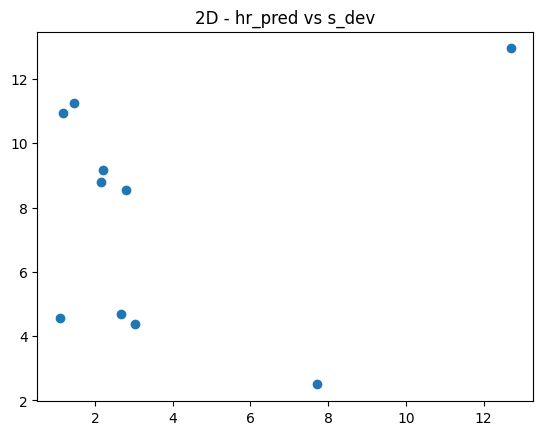

24/24 [==============================] - 0s 1ms/step
[[ 2.1921732 ]
 [ 1.3246665 ]
 [ 2.0119073 ]
 [ 2.9079869 ]
 [ 0.9327313 ]
 [ 2.2895992 ]
 [12.485713  ]
 [ 1.7105573 ]
 [ 3.231196  ]
 [ 6.164912  ]
 [ 1.9067614 ]
 [ 3.5834663 ]
 [ 2.405161  ]
 [ 0.92726934]
 [ 1.6954371 ]
 [ 1.1937814 ]
 [ 3.4340532 ]
 [ 2.0878873 ]
 [ 4.6235943 ]
 [ 4.6853304 ]
 [ 5.0554795 ]
 [ 1.8352394 ]
 [ 1.4053319 ]
 [ 1.7218161 ]]


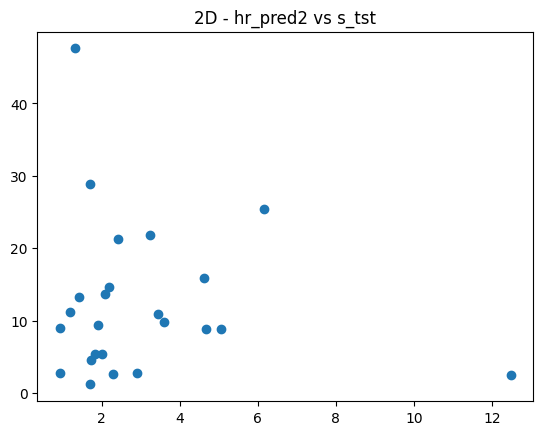

Index 
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 236, 236, 1)]        0         []                            
                                                                                                  
 conv2d_4 (Conv2D)           (None, 236, 1, 128)          30336     ['input_3[0][0]']             
                                                                                                  
 conv2d_5 (Conv2D)           (None, 1, 236, 8)            1896      ['input_3[0][0]']             
                                                                                                  
 max_pooling2d_4 (MaxPoolin  (None, 118, 1, 128)          0         ['conv2d_4[0][0]']            
 g2D)                                                                                

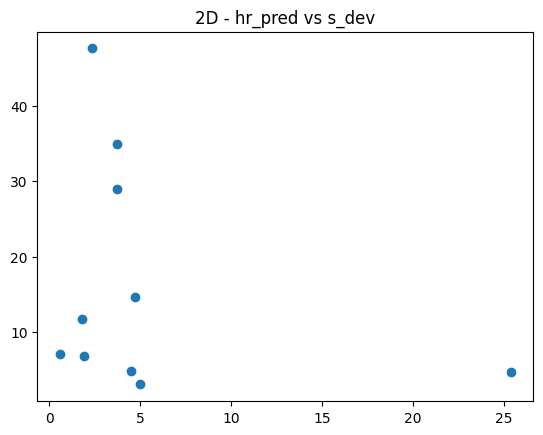

24/24 [==============================] - 0s 1ms/step
[[ 4.9550204 ]
 [ 4.612248  ]
 [ 3.0219522 ]
 [ 3.3352976 ]
 [10.01433   ]
 [ 6.231142  ]
 [ 1.6829634 ]
 [ 1.7104261 ]
 [14.598394  ]
 [ 1.5556684 ]
 [ 8.864415  ]
 [ 1.857962  ]
 [ 1.6259055 ]
 [ 3.8535204 ]
 [15.085268  ]
 [ 3.9585123 ]
 [ 2.8950486 ]
 [ 2.879907  ]
 [ 5.975198  ]
 [ 0.80893266]
 [13.283967  ]
 [ 2.7144756 ]
 [ 3.1769366 ]
 [ 7.6617    ]]


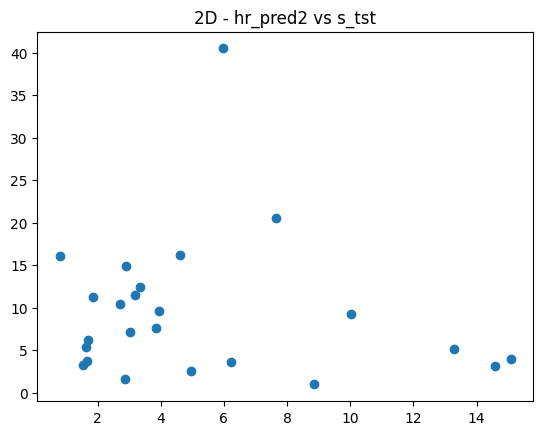

Index 
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 236, 236, 1)]        0         []                            
                                                                                                  
 conv2d_6 (Conv2D)           (None, 236, 1, 128)          30336     ['input_4[0][0]']             
                                                                                                  
 conv2d_7 (Conv2D)           (None, 1, 236, 8)            1896      ['input_4[0][0]']             
                                                                                                  
 max_pooling2d_6 (MaxPoolin  (None, 118, 1, 128)          0         ['conv2d_6[0][0]']            
 g2D)                                                                                

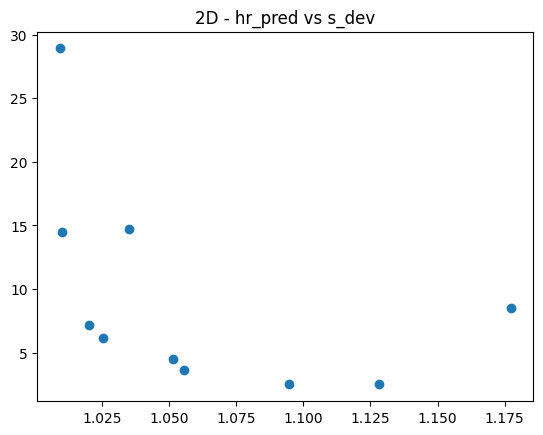

23/23 [==============================] - 0s 1ms/step
[[1.0507082]
 [1.0160491]
 [1.1103327]
 [1.150103 ]
 [1.0541079]
 [1.017098 ]
 [1.0258785]
 [1.1193045]
 [1.0169201]
 [1.0806683]
 [1.0150635]
 [1.0194142]
 [1.0354104]
 [1.0798007]
 [1.0763212]
 [1.0452001]
 [1.010998 ]
 [1.019718 ]
 [1.0189861]
 [1.036622 ]
 [1.0203211]
 [1.0101376]
 [1.0250944]]


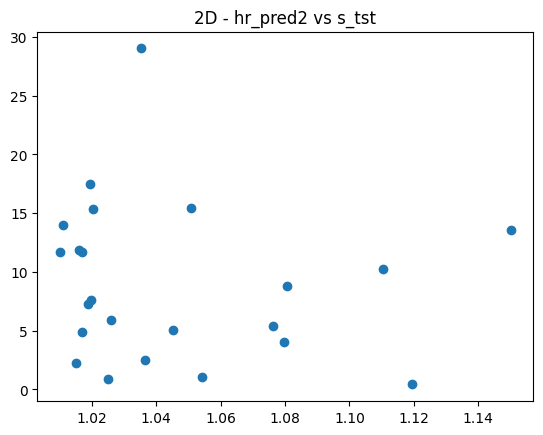

Index 
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 236, 236, 1)]        0         []                            
                                                                                                  
 conv2d_8 (Conv2D)           (None, 236, 1, 128)          30336     ['input_5[0][0]']             
                                                                                                  
 conv2d_9 (Conv2D)           (None, 1, 236, 8)            1896      ['input_5[0][0]']             
                                                                                                  
 max_pooling2d_8 (MaxPoolin  (None, 118, 1, 128)          0         ['conv2d_8[0][0]']            
 g2D)                                                                                

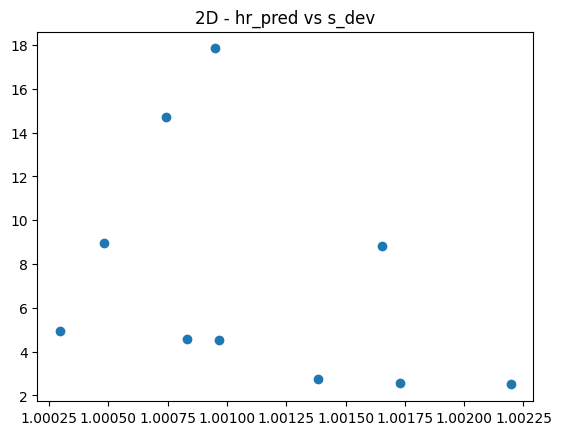

23/23 [==============================] - 0s 1ms/step
[[1.0019511 ]
 [1.0010866 ]
 [1.0010866 ]
 [1.0008247 ]
 [1.0014039 ]
 [1.0001464 ]
 [1.000425  ]
 [1.000302  ]
 [1.0007722 ]
 [0.99976045]
 [1.0003141 ]
 [1.001679  ]
 [1.0009547 ]
 [1.0004324 ]
 [1.0000613 ]
 [1.0005323 ]
 [1.0005602 ]
 [1.0004003 ]
 [0.9999891 ]
 [1.0001837 ]
 [1.0009803 ]
 [1.0005668 ]
 [1.0004936 ]]


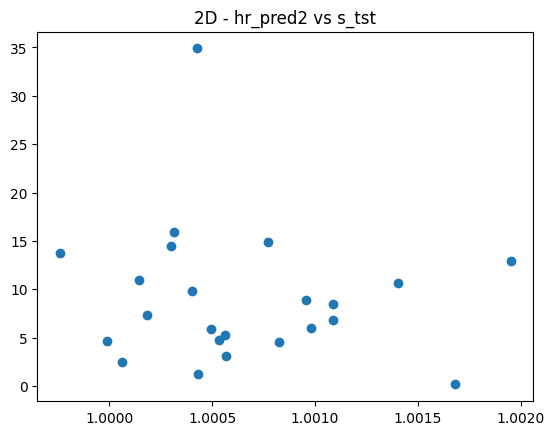

In [32]:
score_tst_list = []
score_dev_list = []

#le, wi = 20, 5

# 236x236 is 55696

#le, wi = 10, 10
le, wi = 236, 236
conv1_size=(1, wi)
conv2_size=(wi, 1)
input_shape = (le, wi, 1)

# using just 1 loop for now
for i in range(0,1):
        print("Range ")
        ci_tst_list = []
        ci_dev_list = []
        kf = StratifiedKFold(n_splits=5,random_state=1,shuffle=True)
        fold = 0
        for trn_index, tst_index in kf.split(X,E):
            print("Index ")
            fold +=1
            x_tst=X[tst_index]
            c_tst=E[tst_index]
            s_tst=Y[tst_index]

            x_trn, x_dev ,c_trn, c_dev , s_trn, s_dev=train_test_split(
                X[trn_index],E[trn_index],Y[trn_index],test_size=0.1,
                stratify=E[trn_index],random_state=1)

            sort_idx = np.argsort(s_trn)[::-1]
            x_trn = x_trn[sort_idx]
            s_trn = s_trn[sort_idx]
            c_trn = c_trn[sort_idx]

            x_trn = np.reshape(x_trn, (-1, le, wi))
            x_dev = np.reshape(x_dev, (-1, le, wi))
            x_tst = np.reshape(x_tst, (-1, le, wi))

            x_trn = x_trn.reshape(x_trn.shape[0], le, wi, 1)
            x_dev = x_dev.reshape(x_dev.shape[0], le, wi, 1)
            x_tst = x_tst.reshape(x_tst.shape[0], le, wi, 1)
        
            #fit
            data = (x_trn, c_trn, s_trn, x_dev, c_dev, s_dev)
            modelpath = save_path+"%s_fold_%s_repeat_%s_%s.hdf5" % (
                cancer_name,fold,i+1,le*wi)
            checkpoint = MyCallback(modelpath, data)
            
            
            

            
            
            conv1=128
            conv2=8
            dense=32
            input_img = Input(input_shape)
            tower_1 = Conv2D(conv1, conv1_size, activation='relu')(input_img)
            tower_1 = MaxPooling2D(1, 2)(tower_1)
            tower_1 = Flatten()(tower_1)
            tower_2 = Conv2D(conv2, conv2_size, activation='relu')(input_img)
            tower_2 = MaxPooling2D(1, 2)(tower_2)
            tower_2 = Flatten()(tower_2)
            output = concatenate([tower_1, tower_2], axis=1)
            out1 = Dense(dense, activation='relu')(output)
            last_layer = Dense(1, kernel_initializer='zeros', bias_initializer='zeros')(out1)
            model = Model(inputs=[input_img], outputs=last_layer)
            
            
            #conv1=128
            #dense=128
            #input_img = Input(input_shape)
            #tower = Conv2D(conv1, conv1_size, activation='relu')(input_img)
            #tower1 = MaxPooling2D(1, 2)(tower)
            #tower2 = Flatten()(tower1)
            #out = Dense(dense, activation='relu')(tower2)
            #last_layer = Dense(1, kernel_initializer='zeros', bias_initializer='zeros')(out)
            #model = Model(inputs=[input_img], outputs=last_layer)

            
            model.compile(loss=[nll(c_trn, np.sum(c_trn))],optimizer="adam")
            print(model.summary())
            
            
            print('Training...')
            history = model.fit(x_trn, s_trn, batch_size=len(x_trn),
                                epochs=100,verbose=0,callbacks=[checkpoint], shuffle=False)
            model.load_weights(modelpath)
        
            hr_pred=model.predict(x_dev,batch_size=1, verbose=1)
            hr_pred=np.exp(hr_pred)
            print(hr_pred)
            fig,ax = plt.subplots(1)
            ax.scatter(hr_pred,s_dev)

            
            #log_pred = [-np.log(p) for p in hr_pred]
            #ax.scatter(hr_pred,log_pred)


            plt.title("2D - hr_pred vs s_dev")
            plt.show()
            ci_dev=concordance_index(s_dev,-hr_pred,c_dev)
            
            hr_pred2=model.predict(x_tst,batch_size=1, verbose=1)
            hr_pred2=np.exp(hr_pred2)
            print(hr_pred2)
            fig,ax = plt.subplots(1)
            ax.scatter(hr_pred2,s_tst)
            plt.title("2D - hr_pred2 vs s_tst")
            plt.show()
            ci_tst=concordance_index(s_tst,-hr_pred2,c_tst)
            
            ci_dev_list.append(ci_dev)
            ci_tst_list.append(ci_tst)
            
        score_dev_list.append(ci_dev_list)
        score_tst_list.append(ci_tst_list)



If the hazard ratio is less than 1, then the predictor is protective (i.e., associated with improved survival) and if the hazard ratio is greater than 1, then the predictor is associated with increased risk (or decreased survival).
